LSTM model to forecast Carbon Intensity 

In [ ]:
# Import necessary libraries (PyTorch version)
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nnprint("\n🎯 PyTorch LSTM deep learning model completed!")
print("🔥 Ready for anomaly detection and final analysis!")
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cpu
CUDA Available: False


In [3]:
# Load the processed data
df = pd.read_csv("processed_data.csv")

print(f"🧠 PyTorch LSTM Carbon Intensity Forecasting")
print("="*60)
print(f"Processed data shape: {df.shape}")
print(f"Date range: {df['Datetime_UTC'].min()} to {df['Datetime_UTC'].max()}")

# Sort by datetime and zone for proper time series structure
df['Datetime_UTC'] = pd.to_datetime(df['Datetime_UTC'])
df = df.sort_values(['Zone_encoded', 'Datetime_UTC']).reset_index(drop=True)

print(f"Data sorted by Zone and DateTime")

🧠 PyTorch LSTM Carbon Intensity Forecasting
Processed data shape: (175320, 25)
Date range: 2021-01-01 00:00:00 to 2024-12-31 23:00:00
Data sorted by Zone and DateTime


In [4]:
# Prepare time series features for LSTM
def create_sequences(data, target, lookback_window=24, forecast_horizon=1):
    """
    Create sequences for LSTM training
    lookback_window: number of time steps to look back (24h = 24 hours)
    forecast_horizon: number of steps ahead to predict (1 = next hour)
    """
    X, y = [], []
    
    for i in range(lookback_window, len(data) - forecast_horizon + 1):
        # Features: past 'lookback_window' time steps
        X.append(data[i-lookback_window:i])
        # Target: next 'forecast_horizon' time steps
        if forecast_horizon == 1:
            y.append(target[i])
        else:
            y.append(target[i:i+forecast_horizon])
    
    return np.array(X), np.array(y)

# Select features for LSTM (time-sensitive features)
lstm_features = [
    'Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter',
    'Zone_encoded',
    'Renewable_energy_percentage_RE%', 
    'Carbon-free_energy_percentage_CFE%',
    'Carbon_Efficiency', 
    'Clean_Energy_Gap',
    'Carbon_Intensity_MA_24h', 
    'RE_Percentage_MA_24h'
]

# Filter existing features
lstm_features = [col for col in lstm_features if col in df.columns]
target_col = 'Carbon_intensity_gCO₂eq_kWh_direct'

print(f"LSTM Features: {lstm_features}")
print(f"Number of features: {len(lstm_features)}")

LSTM Features: ['Hour', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Zone_encoded', 'Renewable_energy_percentage_RE%', 'Carbon-free_energy_percentage_CFE%', 'Carbon_Efficiency', 'Clean_Energy_Gap', 'Carbon_Intensity_MA_24h', 'RE_Percentage_MA_24h']
Number of features: 12


In [6]:
# Prepare data for each zone separately (important for time series integrity)
zones = df['Zone_encoded'].unique()
print(f"Processing {len(zones)} zones: {zones}")

# Parameters
LOOKBACK_WINDOW = 24  # Use past 24 hours to predict next hour
FORECAST_HORIZON = 1  # Predict next 1 hour
TEST_SIZE = 0.2       # Last 20% of data for testing

# Store all sequences
X_sequences_all = []
y_sequences_all = []
zone_info = []

for zone in zones:
    zone_data = df[df['Zone_encoded'] == zone].copy()
    
    if len(zone_data) > LOOKBACK_WINDOW + 10:  # Ensure enough data
        # Prepare features and target
        X_zone = zone_data[lstm_features].values
        y_zone = zone_data[target_col].values
        
        # Create sequences
        X_seq, y_seq = create_sequences(X_zone, y_zone, LOOKBACK_WINDOW, FORECAST_HORIZON)
        
        if len(X_seq) > 0:
            X_sequences_all.append(X_seq)
            y_sequences_all.append(y_seq)
            zone_info.extend([zone] * len(X_seq))
            
            print(f"Zone {zone}: {len(zone_data)} samples → {len(X_seq)} sequences")

# Combine all sequences
X_lstm = np.concatenate(X_sequences_all, axis=0)
y_lstm = np.concatenate(y_sequences_all, axis=0)
zone_info = np.array(zone_info)

print(f"\nTotal LSTM sequences created:")
print(f"X shape: {X_lstm.shape} (samples, time_steps, features)")
print(f"y shape: {y_lstm.shape}")

Processing 5 zones: [0 1 2 3 4]
Zone 0: 35064 samples → 35040 sequences
Zone 1: 35064 samples → 35040 sequences
Zone 2: 35064 samples → 35040 sequences
Zone 3: 35064 samples → 35040 sequences
Zone 4: 35064 samples → 35040 sequences

Total LSTM sequences created:
X shape: (175200, 24, 12) (samples, time_steps, features)
y shape: (175200,)


In [7]:
# Train-test split (time-aware)
split_idx = int((1 - TEST_SIZE) * len(X_lstm))

X_train_lstm = X_lstm[:split_idx]
X_test_lstm = X_lstm[split_idx:]
y_train_lstm = y_lstm[:split_idx]
y_test_lstm = y_lstm[split_idx:]

print(f"LSTM Training set: {X_train_lstm.shape}")
print(f"LSTM Test set: {X_test_lstm.shape}")
print(f"Training samples: {len(X_train_lstm)}")
print(f"Test samples: {len(X_test_lstm)}")

LSTM Training set: (140160, 24, 12)
LSTM Test set: (35040, 24, 12)
Training samples: 140160
Test samples: 35040


In [8]:
# Scale the data (important for LSTM)
# Scale features (per time step)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape for scaling (combine time steps and features)
X_train_reshaped = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])
X_train_scaled_reshaped = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled_reshaped.reshape(X_train_lstm.shape)

X_test_reshaped = X_test_lstm.reshape(-1, X_test_lstm.shape[-1])
X_test_scaled_reshaped = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test_lstm.shape)

# Scale target
y_train_scaled = scaler_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_lstm.reshape(-1, 1)).flatten()

print("✅ Data scaling completed")
print(f"Scaled X_train shape: {X_train_scaled.shape}")
print(f"Scaled y_train shape: {y_train_scaled.shape}")

✅ Data scaling completed
Scaled X_train shape: (140160, 24, 12)
Scaled y_train shape: (140160,)


In [10]:
# Define PyTorch LSTM Model Class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the last output
        out = out[:, -1, :]
        
        # Dense layers with dropout and activation
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

# Training function for PyTorch
def train_pytorch_lstm(model, train_loader, val_loader, epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_pytorch_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= 15:
                print(f"Early stopping at epoch {epoch}")
                break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_pytorch_lstm_model.pth'))
    return train_losses, val_losses

# Initialize the model
input_size = X_train_scaled.shape[2]  # Number of features
lstm_model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# Model summary
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print(f"\n🏗️ PyTorch LSTM Model Architecture:")
print(f"Input size: {input_size}")
print(f"Hidden size: 64")
print(f"Number of layers: 2")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model: {lstm_model}")

🖥️ Using device: cpu

🏗️ PyTorch LSTM Model Architecture:
Input size: 12
Hidden size: 64
Number of layers: 2
Total parameters: 55,873
Trainable parameters: 55,873
Model: LSTMModel(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
# Convert to PyTorch tensors and create data loaders
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create validation split from training data
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Data loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

✅ Data loaders created:
Training batches: 1752
Validation batches: 438
Test batches: 548


In [12]:
# Train the model
print("🚀 Training PyTorch LSTM model...")

train_losses, val_losses = train_pytorch_lstm(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001
)

print("✅ LSTM model training completed!")

🚀 Training PyTorch LSTM model...
Epoch 0: Train Loss: 0.050172, Val Loss: 0.017356
Epoch 10: Train Loss: 0.004591, Val Loss: 0.010014
Epoch 20: Train Loss: 0.003354, Val Loss: 0.005989
Epoch 30: Train Loss: 0.002796, Val Loss: 0.006305
Early stopping at epoch 40
✅ LSTM model training completed!


In [13]:
# Make predictions
print("🔮 Making predictions...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.eval()

# Training predictions
train_predictions = []
train_actuals = []
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        pred = lstm_model(batch_X)
        train_predictions.append(pred.cpu().numpy())
        train_actuals.append(batch_y.numpy())

y_pred_train_scaled = np.concatenate(train_predictions).flatten()
y_train_actual_scaled = np.concatenate(train_actuals).flatten()

# Test predictions
test_predictions = []
test_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        pred = lstm_model(batch_X)
        test_predictions.append(pred.cpu().numpy())
        test_actuals.append(batch_y.numpy())

y_pred_test_scaled = np.concatenate(test_predictions).flatten()
y_test_actual_scaled = np.concatenate(test_actuals).flatten()

# Inverse transform to original scale
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train_actual_scaled.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test_actual_scaled.reshape(-1, 1)).flatten()

print("✅ Predictions completed and scaled back to original units")

🔮 Making predictions...
✅ Predictions completed and scaled back to original units


In [14]:
# Calculate comprehensive metrics
train_mae = mean_absolute_error(y_train_actual, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
train_r2 = r2_score(y_train_actual, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train_actual, y_pred_train) * 100

test_mae = mean_absolute_error(y_test_actual, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
test_r2 = r2_score(y_test_actual, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test_actual, y_pred_test) * 100

# Display results
print("="*60)
print("🧠 PYTORCH LSTM - CARBON INTENSITY FORECASTING")
print("="*60)
print(f"Training Metrics:")
print(f"  MAE:  {train_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {train_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")
print(f"\nTest Metrics:")
print(f"  MAE:  {test_mae:.4f} gCO₂eq/kWh")
print(f"  RMSE: {test_rmse:.4f} gCO₂eq/kWh")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")
print("="*60)

🧠 PYTORCH LSTM - CARBON INTENSITY FORECASTING
Training Metrics:
  MAE:  0.0531 gCO₂eq/kWh
  RMSE: 0.0654 gCO₂eq/kWh
  R²:   0.9953
  MAPE: 23.06%

Test Metrics:
  MAE:  0.1281 gCO₂eq/kWh
  RMSE: 0.1520 gCO₂eq/kWh
  R²:   0.8331
  MAPE: 35.87%


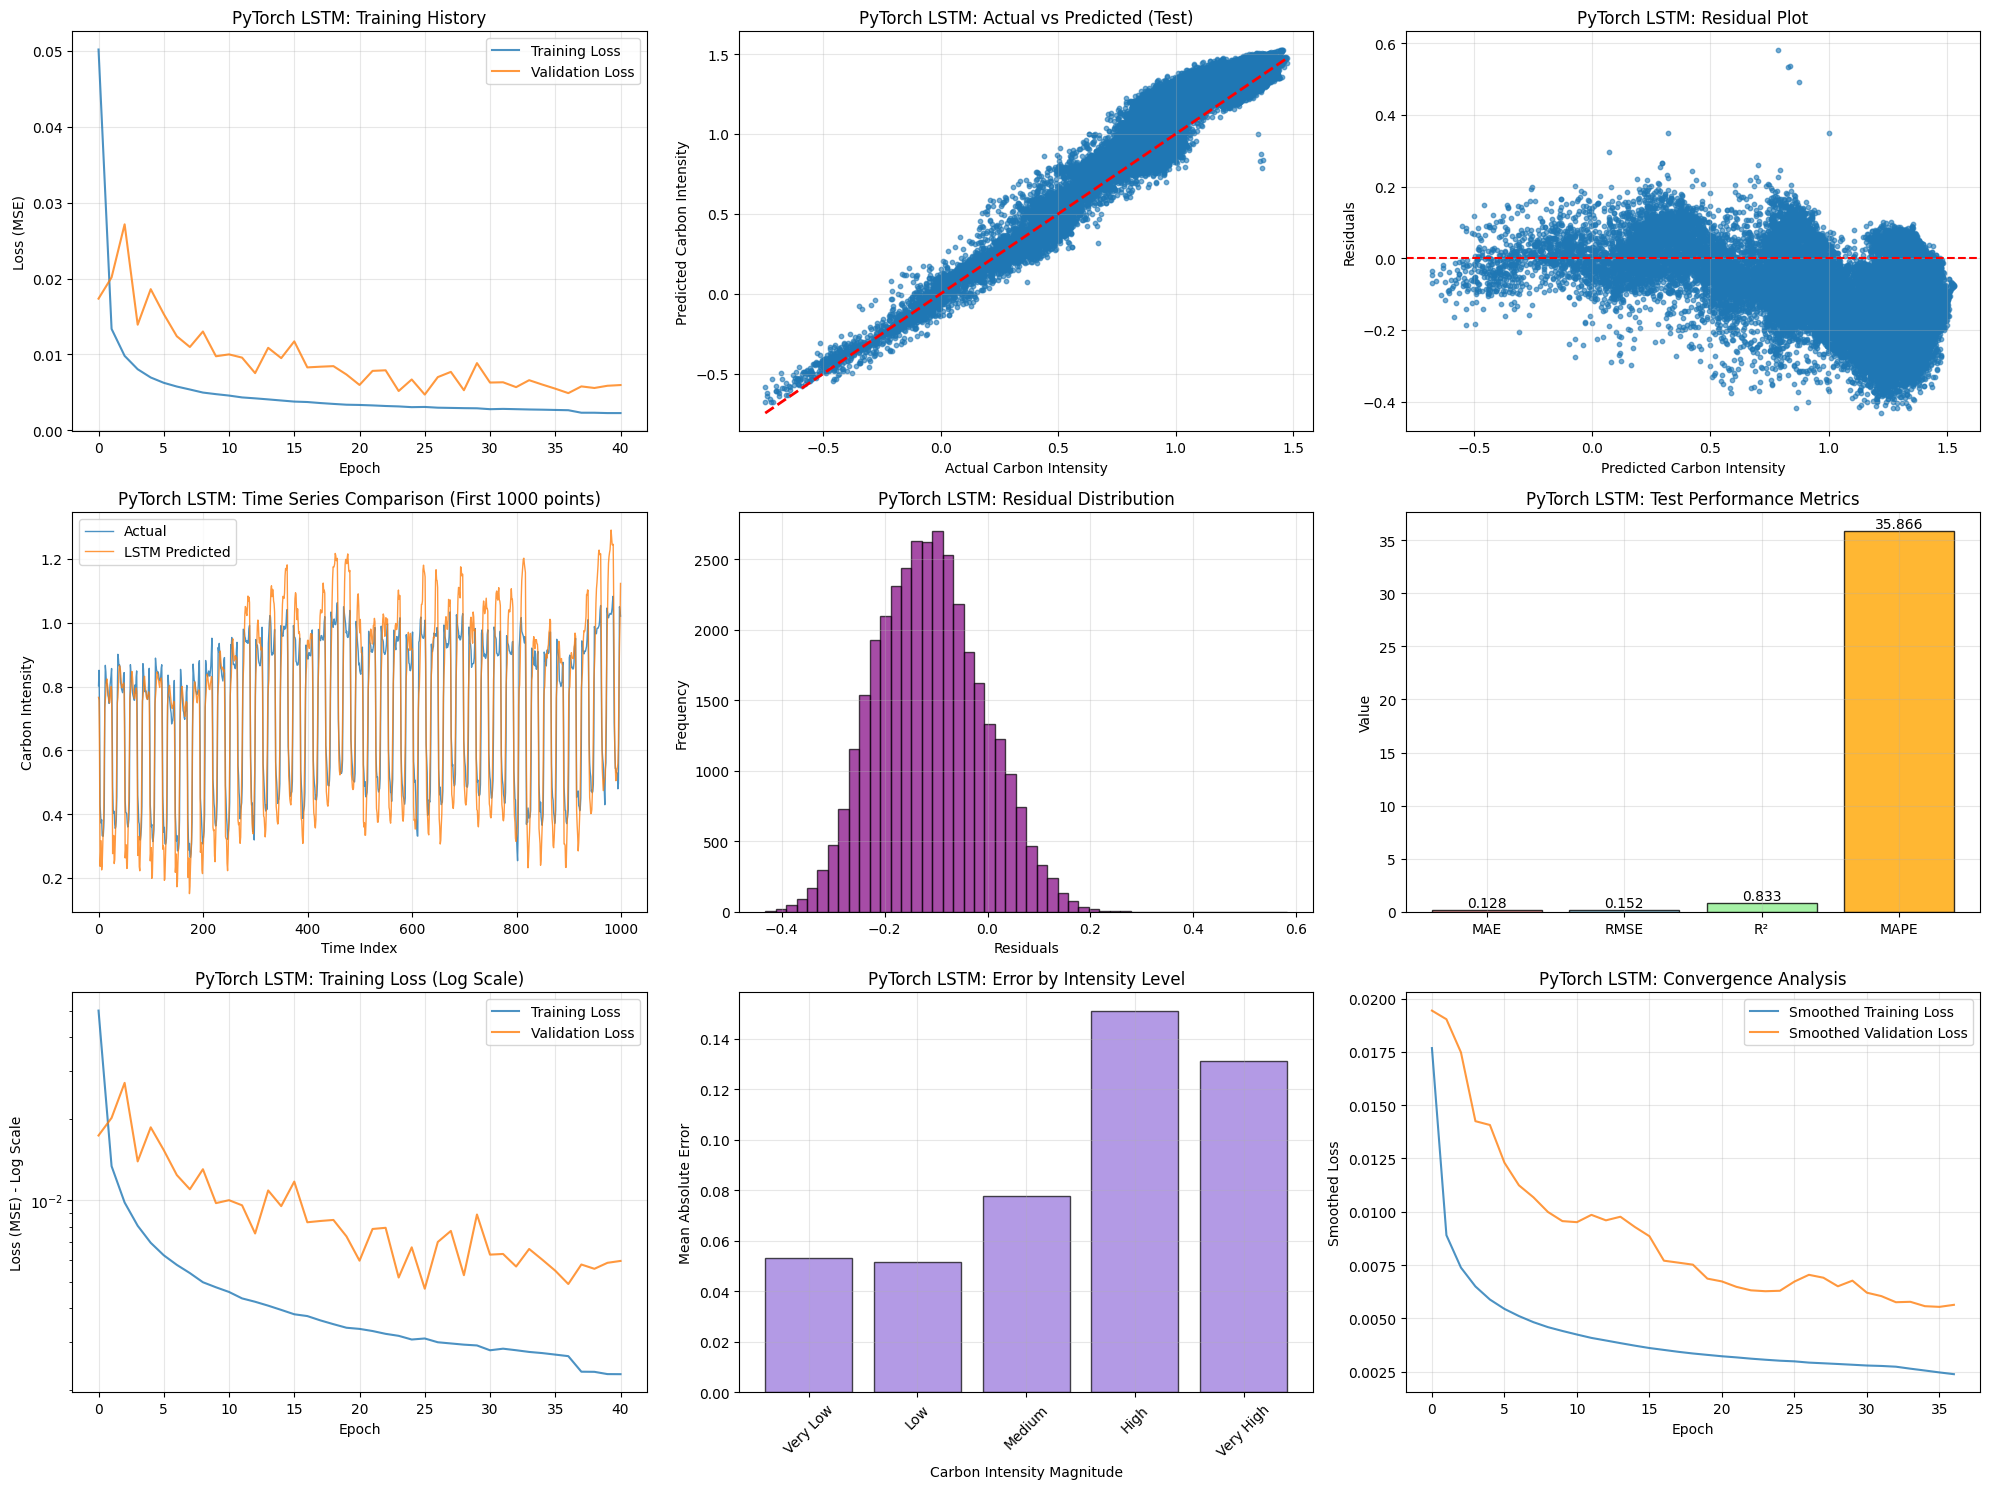

In [15]:
# Comprehensive PyTorch LSTM Visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Training history
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('PyTorch LSTM: Training History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_actual, y_pred_test, alpha=0.6, s=10)
axes[0, 1].plot([y_test_actual.min(), y_test_actual.max()], 
                [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Carbon Intensity')
axes[0, 1].set_ylabel('Predicted Carbon Intensity')
axes[0, 1].set_title('PyTorch LSTM: Actual vs Predicted (Test)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals plot
residuals = y_test_actual - y_pred_test
axes[0, 2].scatter(y_pred_test, residuals, alpha=0.6, s=10)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Carbon Intensity')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('PyTorch LSTM: Residual Plot')
axes[0, 2].grid(True, alpha=0.3)

# 4. Time series comparison (sample)
sample_size = min(1000, len(y_test_actual))
axes[1, 0].plot(y_test_actual[:sample_size], label='Actual', alpha=0.8, linewidth=1)
axes[1, 0].plot(y_pred_test[:sample_size], label='LSTM Predicted', alpha=0.8, linewidth=1)
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Carbon Intensity')
axes[1, 0].set_title(f'PyTorch LSTM: Time Series Comparison (First {sample_size} points)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Error distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('PyTorch LSTM: Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance metrics
metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
values = [test_mae, test_rmse, test_r2, test_mape]
colors = ['lightcoral', 'skyblue', 'lightgreen', 'orange']

bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 2].set_title('PyTorch LSTM: Test Performance Metrics')
axes[1, 2].set_ylabel('Value')
axes[1, 2].grid(True, alpha=0.3)

for bar, value in zip(bars, values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.3f}', ha='center', va='bottom')

# 7. Loss curves (log scale)
axes[2, 0].semilogy(train_losses, label='Training Loss', alpha=0.8)
axes[2, 0].semilogy(val_losses, label='Validation Loss', alpha=0.8)
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss (MSE) - Log Scale')
axes[2, 0].set_title('PyTorch LSTM: Training Loss (Log Scale)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 8. Prediction accuracy by magnitude
magnitude_bins = pd.cut(y_test_actual, bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
accuracy_by_magnitude = pd.DataFrame({
    'magnitude': magnitude_bins,
    'actual': y_test_actual,
    'predicted': y_pred_test,
    'error': np.abs(residuals)
}).groupby('magnitude')['error'].mean()

axes[2, 1].bar(range(len(accuracy_by_magnitude)), accuracy_by_magnitude.values, 
              alpha=0.7, color='mediumpurple', edgecolor='black')
axes[2, 1].set_xticks(range(len(accuracy_by_magnitude)))
axes[2, 1].set_xticklabels(accuracy_by_magnitude.index, rotation=45)
axes[2, 1].set_xlabel('Carbon Intensity Magnitude')
axes[2, 1].set_ylabel('Mean Absolute Error')
axes[2, 1].set_title('PyTorch LSTM: Error by Intensity Level')
axes[2, 1].grid(True, alpha=0.3)

# 9. Model convergence
if len(train_losses) > 10:
    smoothed_train = np.convolve(train_losses, np.ones(5)/5, mode='valid')
    smoothed_val = np.convolve(val_losses, np.ones(5)/5, mode='valid')
    
    axes[2, 2].plot(smoothed_train, label='Smoothed Training Loss', alpha=0.8)
    axes[2, 2].plot(smoothed_val, label='Smoothed Validation Loss', alpha=0.8)
    axes[2, 2].set_xlabel('Epoch')
    axes[2, 2].set_ylabel('Smoothed Loss')
    axes[2, 2].set_title('PyTorch LSTM: Convergence Analysis')
    axes[2, 2].legend()
else:
    axes[2, 2].text(0.5, 0.5, 'Not enough epochs\nfor smoothing', 
                   ha='center', va='center', transform=axes[2, 2].transAxes)
    axes[2, 2].set_title('PyTorch LSTM: Convergence Analysis')

axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Model Comparison with Previous Models
import os
import json

try:
    # Load previous model results
    model_results = []
    
    # Linear Regression
    if os.path.exists('linear_regression_summary.json'):
        with open('linear_regression_summary.json', 'r') as f:
            lr_summary = json.load(f)
        model_results.append({
            'Model': 'Linear Regression',
            'MAE': lr_summary['test_metrics']['MAE'],
            'RMSE': lr_summary['test_metrics']['RMSE'],
            'R²': lr_summary['test_metrics']['R²']
        })
    
    # XGBoost
    if os.path.exists('xgboost_summary.json'):
        with open('xgboost_summary.json', 'r') as f:
            xgb_summary = json.load(f)
        model_results.append({
            'Model': 'XGBoost',
            'MAE': xgb_summary['test_metrics']['MAE'],
            'RMSE': xgb_summary['test_metrics']['RMSE'],
            'R²': xgb_summary['test_metrics']['R²']
        })
    
    # PyTorch LSTM
    model_results.append({
        'Model': 'PyTorch LSTM',
        'MAE': test_mae,
        'RMSE': test_rmse,
        'R²': test_r2
    })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results)
    
    print("\n" + "="*60)
    print("📊 COMPREHENSIVE MODEL COMPARISON")
    print("="*60)
    print(comparison_df.round(4))
    
    # Find best model for each metric
    best_mae = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
    best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
    best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
    
    print(f"\n🏆 Best Performing Models:")
    print(f"  Lowest MAE:  {best_mae}")
    print(f"  Lowest RMSE: {best_rmse}")
    print(f"  Highest R²:  {best_r2}")
    
except Exception as e:
    print(f"\n⚠️ Error in model comparison: {e}")


📊 COMPREHENSIVE MODEL COMPARISON
               Model     MAE    RMSE      R²
0  Linear Regression  0.0578  0.0606  0.9735
1            XGBoost  0.0518  0.0606  0.9735
2       PyTorch LSTM  0.1281  0.1520  0.8331

🏆 Best Performing Models:
  Lowest MAE:  XGBoost
  Lowest RMSE: XGBoost
  Highest R²:  XGBoost


In [ ]:
# Save PyTorch LSTM model and results
print("💾 Saving PyTorch LSTM model and results...")

# Save the model
torch.save(lstm_model.state_dict(), 'pytorch_lstm_model.pth')
joblib.dump(scaler_X, 'pytorch_lstm_scaler_X.pkl')
joblib.dump(scaler_y, 'pytorch_lstm_scaler_y.pkl')

# Save comprehensive results
results_df = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_pred_test,
    'residuals': residuals,
    'abs_error': np.abs(residuals),
    'percentage_error': np.abs(residuals) / y_test_actual * 100
})

results_df.to_csv('pytorch_lstm_results.csv', index=False)

# Save model summary
model_summary = {
    'model_type': 'PyTorch LSTM Deep Learning',
    'model_architecture': {
        'input_size': input_size,
        'hidden_size': 64,
        'num_layers': 2,
        'dropout_rate': 0.2,
        'lookback_window': LOOKBACK_WINDOW,
        'forecast_horizon': FORECAST_HORIZON,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params
    },
    'target_variable': target_col,
    'features_used': lstm_features,
    'training_samples': len(X_train_lstm),
    'test_samples': len(X_test_lstm),
    'training_history': {
        'epochs_trained': len(train_losses),
        'final_train_loss': float(train_losses[-1]) if train_losses else None,
        'final_val_loss': float(val_losses[-1]) if val_losses else None,
        'best_val_loss': float(min(val_losses)) if val_losses else None
    },
    'test_metrics': {
        'MAE': float(test_mae),
        'RMSE': float(test_rmse),
        'R²': float(test_r2),
        'MAPE': float(test_mape)
    }
}

with open('pytorch_lstm_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print("✅ PyTorch LSTM model saved as 'pytorch_lstm_model.pth'")
print("✅ Scalers saved as 'pytorch_lstm_scaler_X.pkl' and 'pytorch_lstm_scaler_y.pkl'")
print("✅ Results saved as 'pytorch_lstm_results.csv'")
print("✅ Summary saved as 'pytorch_lstm_summary.json'")


💾 Saving PyTorch LSTM model and results...
✅ PyTorch LSTM model saved as 'pytorch_lstm_model.pth'
✅ Scalers saved as 'pytorch_lstm_scaler_X.pkl' and 'pytorch_lstm_scaler_y.pkl'
✅ Results saved as 'pytorch_lstm_results.csv'
✅ Summary saved as 'pytorch_lstm_summary.json'

🎯 PyTorch LSTM deep learning model completed!
🔥 Ready for anomaly detection and final analysis!
